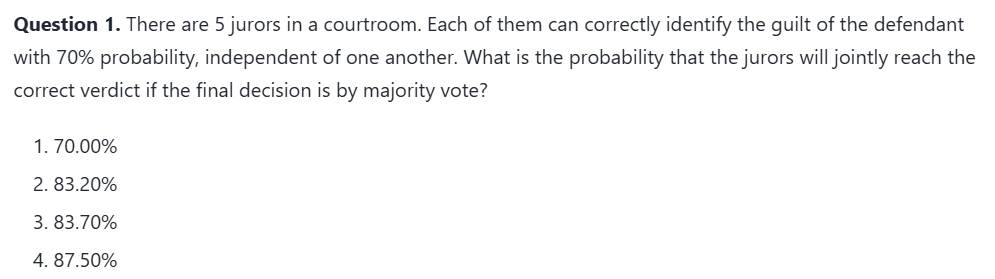

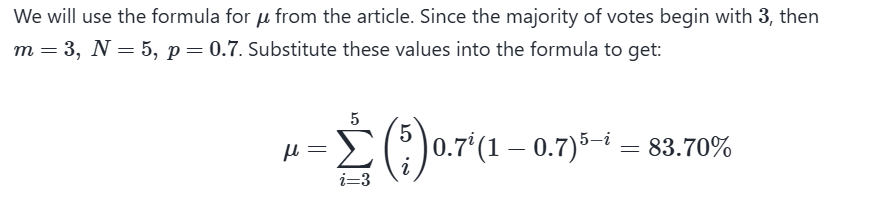

In [122]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [123]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [124]:
# replace Nan values with median for each column
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [125]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [126]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

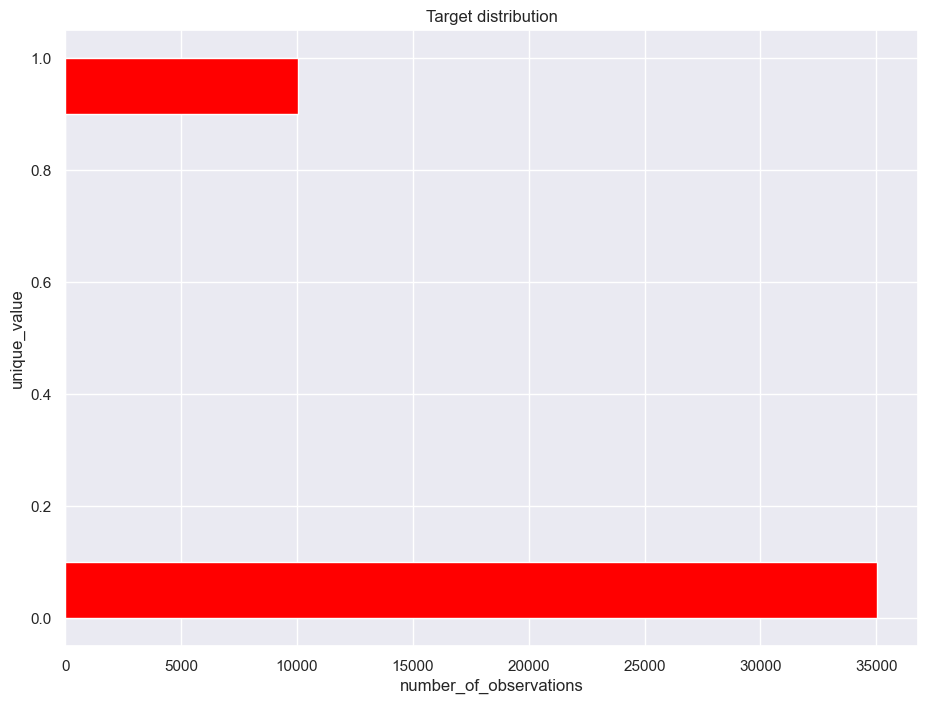

In [127]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [128]:
#Separate the input variable names by excluding the target:

independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [129]:
table = fill_nan(data)

In [130]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

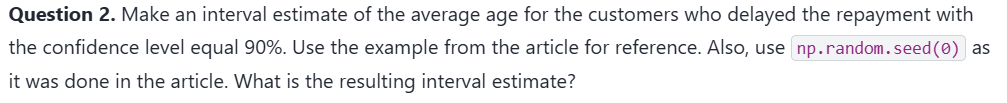

In [131]:
def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# Save the ages of those who let a delay
churn = data[data["SeriousDlqin2yrs"] == 1]["age"].values

# Set the random seed for reproducibility
np.random.seed(0)

# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]

# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))

Mean interval [45.71379414 46.12700479]


In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [133]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

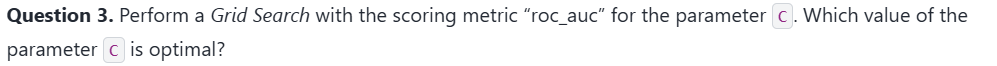

In [134]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)


grid_search = GridSearchCV(lr, parameters, n_jobs=-1, scoring="roc_auc", cv=skf)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [135]:
grid_search.best_params_

{'C': 0.001}

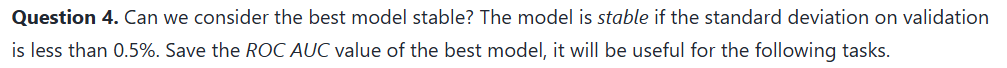

In [136]:
grid_search.cv_results_["std_test_score"][1]

0.008137559189742445

In [137]:
grid_search.best_score_

0.8089120626797153

In [138]:

# FEATURE IMPORTANCE WITHOUT SCALING

coef = abs(grid_search.best_estimator_.coef_)
c = [coef[0,x] for x in range(coef.shape[1])]
coefi = pd.DataFrame({"abs_coef" : c}, index = independent_columns_names)

coefi.sort_values(by="abs_coef", ascending =False)

,abs_coef
NumberOfTime30-59DaysPastDueNotWorse,0.446832
NumberOfTimes90DaysLate,0.390380
NumberOfTime60-89DaysPastDueNotWorse,0.216038
NumberOfDependents,0.191726
age,0.013656
MonthlyIncome,0.000011
DebtRatio,0.000006


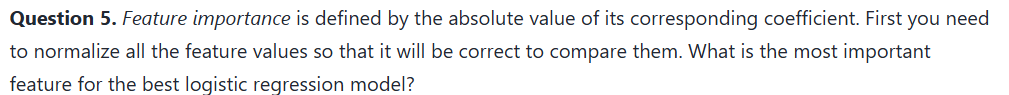

In [139]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

d = pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)
d

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


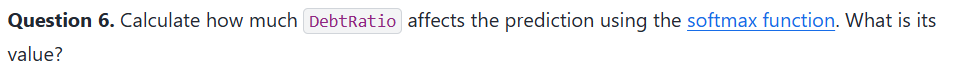

In [ ]:
#1
def softmax(array):
    div = array.apply(lambda x : np.e**x).sum()
    return np.asarray([(np.e **z)/div for z in array])

#Q6
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

d["soft_max"] = softmax(d["coef"])
d

0.11426375283065285


,feat,coef,soft_max
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427,0.241298
3,NumberOfTimes90DaysLate,0.516788,0.196251
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558,0.142048
6,NumberOfDependents,0.101443,0.129548
2,DebtRatio,-0.024096,0.114264
5,MonthlyIncome,-0.163146,0.099431
0,age,-0.416702,0.077162


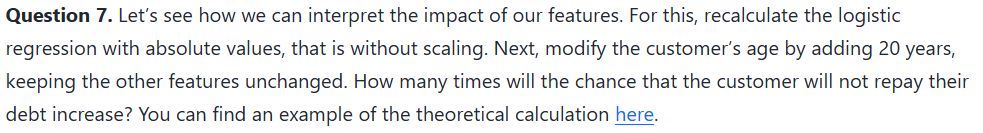

In [141]:
lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lr.fit(X, y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390380
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [142]:
np.exp(lr.coef_[0][0] * 20)  # e ^ [B(feature coef) * C (feature increment)]
# we picked age 

0.7610089717690132

In [147]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

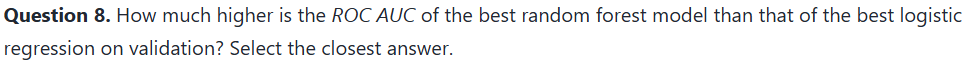

In [149]:
rf_search = GridSearchCV(rf, parameters, n_jobs= -1, scoring= "roc_auc", cv = skf)
rf_search.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [150]:
rf_search.best_score_ - grid_search.best_score_

0.026866475306627002

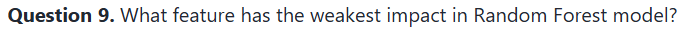

In [ ]:
independent_columns_names[abs(rf_search.best_estimator_.feature_importances_).argmin()]
#[0.11585997, 0.30028969, 0.0760817 , 0.27874902, 0.15653442, 0.05799435, 0.01449085]

'NumberOfDependents'

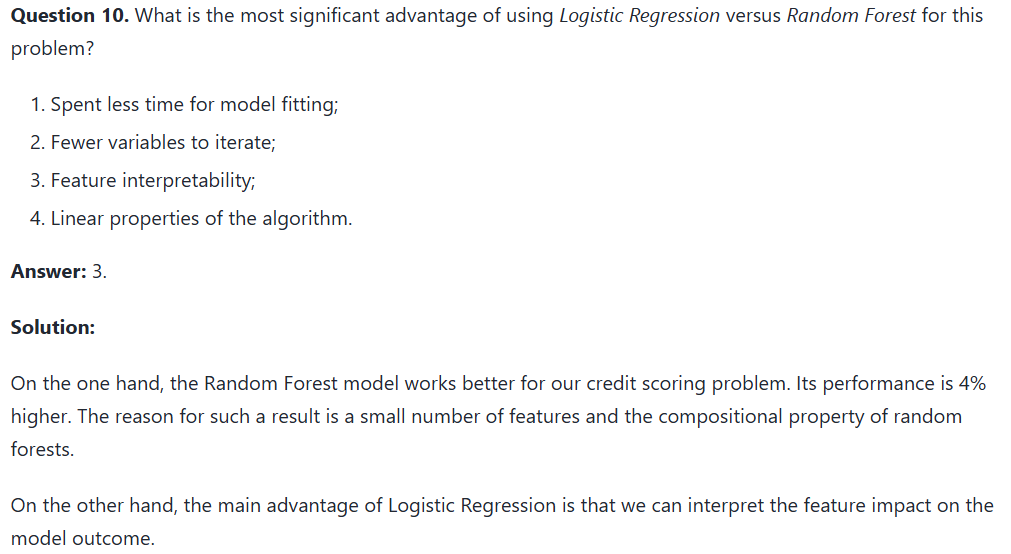

In [157]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

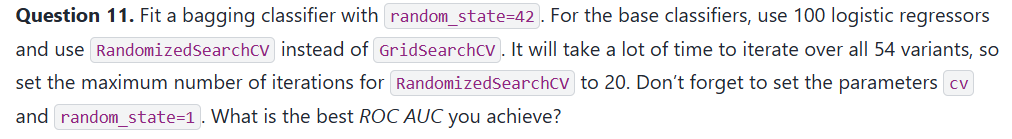

In [158]:
bgc = BaggingClassifier(estimator= lr, n_estimators=100, random_state=42, )

rand_search = RandomizedSearchCV(bgc, parameters, n_jobs= -1,n_iter= 20, scoring="roc_auc", cv=skf, random_state= 1)


In [159]:
rand_search.fit(X,y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(estimator=LogisticRegression(C=0.001,
                                                                            class_weight='balanced',
                                                                            random_state=5),
                                               n_estimators=100,
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   scoring='roc_auc')

In [160]:
rand_search.best_score_

0.8087745786752851

In [161]:
rand_search.best_params_

{'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 1}

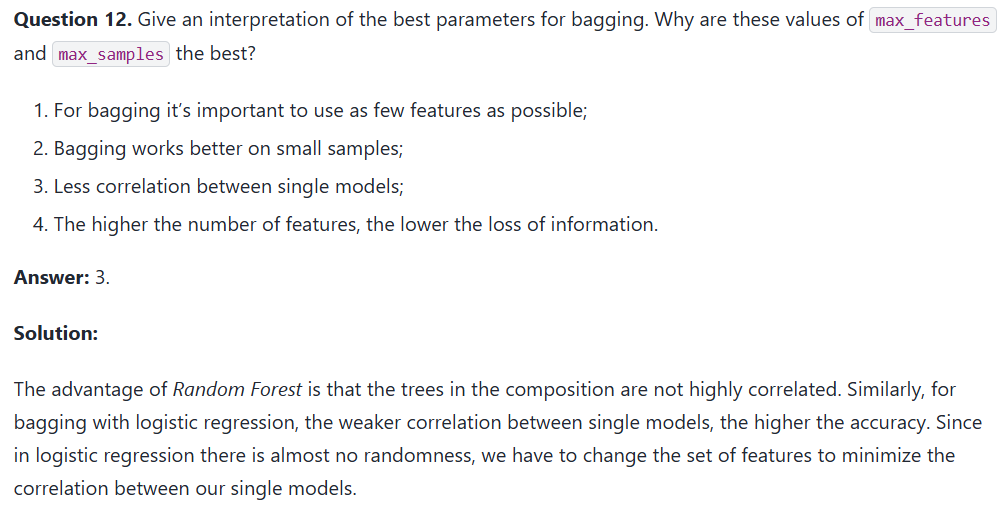